# Random Forest Model Tuning

In prior notebooks, we selected 35 features of the database below to feed into various machine learning models.  For this notebook, we started with the 35 selected features and tuned the Random Forest model, using RandomizedSearchCV and GridSearchCV.  At above 90% F1 score and AUC score, the RF and linear regression and other models could not be improved much.  


## Table of Contents:
&nbsp;&nbsp;1. [Set Up Environment and Read / Clean Data](#1)
   
&nbsp;&nbsp;2. [Methodology](#2)   

&nbsp;&nbsp;3. [Feature Selection](#3)   

&nbsp;&nbsp;4. [Traning Algorithms on Training Dataset](#4)

&nbsp;&nbsp;5. [Evaluate Performances of the Algorithms on Validation Dataset](#5)

## 1. Set Up Environment and Read/Clean Data <a id="1"></a>

In [62]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# memorize these
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# xgboost not available in my Anaconda installation; perhaps try another time
# import xgboost as xgb  

from matplotlib import pyplot as mp
import seaborn as sns
import os
import time
import datetime  

import warnings
warnings.filterwarnings('ignore')

In [3]:
# create script with all code to clean/process data?

In [12]:
df=pd.read_csv('current_Cleaned.csv')

Label = df["Regime"].apply(lambda regime: 1. if regime == 'Normal' else 0.)
df.insert(loc=2, column="Label", value=Label.values)
df.head(10)

,Date,Regime,Label,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
0,9/1/1960,Recession,0.0,-0.290373,-0.306524,-0.218191,0.398556,-0.319682,-0.763685,-0.629582,...,-0.075815,-0.091666,-0.084988,-0.083617,-0.097361,-0.051949,0.020924,-0.386277,-0.444854,-0.573763
1,10/1/1960,Recession,0.0,-0.217081,-0.173129,-0.210746,-0.973246,-0.239855,-0.307588,0.062170,...,-0.080322,-0.083752,-0.101420,-0.087525,-0.088941,0.161980,0.123243,-0.473645,-0.467126,-0.394221
2,11/1/1960,Recession,0.0,-0.532766,-0.588782,-0.780285,-0.608707,-0.430178,-0.934799,-0.744740,...,-0.083527,-0.086557,-0.093805,-0.093738,-0.086234,-0.124278,0.018317,-0.594201,-0.438992,-0.503138
3,12/1/1960,Recession,0.0,-0.543899,-0.592648,-1.379604,0.070352,-0.371547,-1.162951,-0.917778,...,-0.094145,-0.075438,-0.092402,-0.085321,-0.074406,0.058322,-0.051666,-0.567552,-0.383918,-0.586576
4,1/1/1961,Normal,1.0,0.041858,0.083996,-0.378258,-1.599981,-0.305701,-0.193512,-0.283706,...,-0.102158,-0.079946,-0.084487,-0.101754,-0.075108,0.065230,0.163456,-0.416477,-0.471499,-0.382717
5,2/1/1961,Normal,1.0,-0.178812,-0.316191,-0.292640,0.225129,-0.340879,-0.307588,-0.168347,...,-0.098452,-0.083151,-0.087292,-0.094139,-0.075208,-0.048388,-0.124399,-0.392998,-0.592350,-0.556864
6,3/1/1961,Normal,1.0,-0.164786,-0.089998,0.302956,0.668973,-0.226776,0.034640,0.004490,...,-0.088736,-0.093769,-0.076171,-0.092736,-0.083829,-0.004287,0.059219,-0.454624,-0.565636,-0.444961
7,4/1/1961,Normal,1.0,-0.250276,-0.159596,-0.508544,-1.336762,-0.456336,0.718684,0.523404,...,-0.113377,-0.101783,-0.080680,-0.084820,-0.087738,-0.006117,0.066166,-0.254647,-0.414191,-0.467412
8,5/1/1961,Normal,1.0,-0.002858,-0.039733,-0.125129,0.847767,-0.191597,0.490738,0.119849,...,-0.111674,-0.098076,-0.083886,-0.087625,-0.093953,-0.061874,-0.048086,-0.404720,-0.390655,-0.439052
9,6/1/1961,Normal,1.0,0.072565,0.060797,-0.374535,0.467097,-0.251581,0.433700,0.292687,...,-0.113978,-0.088360,-0.094506,-0.076503,-0.085533,-0.062149,-0.003739,-0.331502,-0.452431,-0.383537


In [5]:
features=pd.read_csv('features.csv').columns
features

Index(['DPCERA3M086SBEA', 'IPFPNSS', 'HWI', 'UNRATE', 'CLAIMSx', 'PAYEMS',
       'SRVPRD', 'USTPU', 'USWTRADE', 'USFIRE', 'HOUSTW', 'S&P div yield',
       'TB3MS', 'TB3SMFFM', 'IPMAT 9M lag', 'CLF16OV 9M lag', 'CLAIMSx 9M lag',
       'DMANEMP 12M lag', 'USFIRE 3M lag', 'BUSLOANS 6M lag', 'S&P 500 6M lag',
       'S&P div yield 3M lag', 'TB3MS 6M lag', 'TB3MS 12M lag', 'TB6MS 6M lag',
       'AAA 3M lag', 'TB3SMFFM 3M lag', 'T1YFFM 6M lag', 'T5YFFM 6M lag',
       'T10YFFM 6M lag', 'T10YFFM 12M lag', 'BAAFFM 9M lag', 'EXUSUKx 12M lag',
       'OILPRICEx 9M lag', 'CUSR0000SAD 3M lag'],
      dtype='object')

In [14]:
df_2=df[features]
df_2.insert(loc=0, column="Date", value=df['Date'].values)
df_2.insert(loc=1, column="Regime", value=df['Regime'].values)
df_2.insert(loc=2, column="Label", value=df['Label'].values)
df_2.shape

df=df_2
df.head()
# now we have the most important features to work with 

,Date,Regime,Label,DPCERA3M086SBEA,IPFPNSS,HWI,UNRATE,CLAIMSx,PAYEMS,SRVPRD,...,AAA 3M lag,TB3SMFFM 3M lag,T1YFFM 6M lag,T5YFFM 6M lag,T10YFFM 6M lag,T10YFFM 12M lag,BAAFFM 9M lag,EXUSUKx 12M lag,OILPRICEx 9M lag,CUSR0000SAD 3M lag
0,9/1/1960,Recession,0.0,-0.218191,-0.629582,-0.432705,-0.554785,-0.414377,-0.924099,-1.052279,...,-0.040328,-0.557680,0.172166,-0.199955,-0.405162,-0.093087,-0.870706,-0.095580,-0.023431,0.000790
1,10/1/1960,Recession,0.0,-0.210746,0.062170,-0.444573,3.435803,1.196064,-1.126618,-0.916447,...,-0.176506,-0.656049,0.094279,-0.273669,-0.435747,-0.319440,-0.841508,0.124343,-0.023431,0.418166
2,11/1/1960,Recession,0.0,-0.780285,-0.744740,-0.189401,0.015299,0.495290,-1.612662,-1.299972,...,-0.585042,-0.304732,0.405827,-0.074641,-0.350108,-0.331676,-0.831775,-0.037981,-0.023431,0.000790
3,12/1/1960,Recession,0.0,-1.379604,-0.917778,-0.480178,2.865719,-0.624498,-1.805055,-0.820566,...,-0.131114,0.482217,-0.009571,0.043302,-0.148244,-0.227675,-0.812309,-0.056308,-0.023431,-0.833962
4,1/1/1961,Normal,1.0,-0.378258,-0.283706,-0.041045,0.015299,0.468342,-0.994980,-1.228061,...,0.232029,0.411953,-0.100439,-0.133612,-0.246118,-0.209322,-0.875572,0.092925,-0.023431,0.835542


## 4. Training Algorithms on Training Dataset <a id="3"></a>

In [15]:
# Time Series Split
df_idx = df[df.Date == '12/1/1996'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]

Last run on 2020-02-06 11:39:04 US/Eastern
Features included = 35
                              Confusion Matrix
Model :   Mean      Stdev       TN  FP  FN  TP
-----    -----      -----     ----------------
LR   :    0.880    (0.032)    [ 59   2   2 372]
LR_L1:    0.939    (0.022)    [ 55   6   4 370]
LR_L2:    0.930    (0.028)    [ 55   6   3 371]
LDA  :    0.862    (0.062)    [ 47  14   5 369]
KNN  :    0.852    (0.068)    [ 44  17   6 368]
GB   :    0.790    (0.122)    [ 61   0   0 374]
ABC  :    0.878    (0.014)    [ 61   0   0 374]
RF   :    0.920    (0.041)    [ 61   0   0 374]


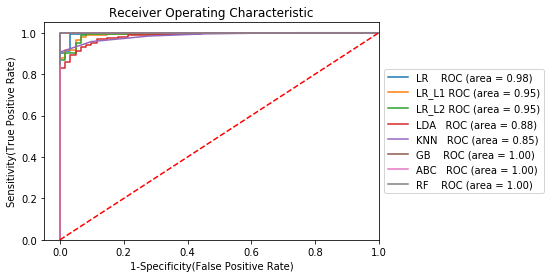

In [16]:
seed=8
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=3) 
models = []

models.append(('LR   ', LogisticRegression(C=1e09)))
models.append(('LR_L1', LogisticRegression(penalty = 'l1')))
models.append(('LR_L2', LogisticRegression(penalty = 'l2')))
models.append(('LDA  ', LinearDiscriminantAnalysis()))
models.append(('KNN  ', KNeighborsClassifier()))
models.append(('GB   ', GradientBoostingClassifier()))
models.append(('ABC  ', AdaBoostClassifier()))
models.append(('RF   ', RandomForestClassifier())) 

# next step could be to try tuning hyperparameters of RF and other models with GridSearchCV and RandomSearchCV

#models.append(('XGB', xgb.XGBClassifier()))

results = []  # will be a list of 8 arrays, each array have 3 roc_auc scores for each of 3 kfold cv runs through each model
names = []
lb = preprocessing.LabelBinarizer()  

ts=time.localtime()
print("Last run on", time.strftime('%Y-%m-%d %H:%M:%S', ts),'US/Eastern')
print("Features included =", len(df_features.columns)) 
print("                              Confusion Matrix")
print("Model :   Mean      Stdev       TN  FP  FN  TP")
print("-----    -----      -----     ----------------")

for name, model in models:
    cv_results = model_selection.cross_val_score(estimator = model, X = df_training_features, 
                                                 y = lb.fit_transform(df_training_targets), cv=kfold, scoring = scoring)
    
    model.fit(df_training_features, df_training_targets) # train the model
    fpr, tpr, thresholds = metrics.roc_curve(df_training_targets, model.predict_proba(df_training_features)[:,1])
    auc = metrics.roc_auc_score(df_training_targets, model.predict(df_training_features))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    results.append(cv_results)
    names.append(name)
    msg = "%s:    %0.3f    (%0.3f)    %s" % (name, cv_results.mean(), cv_results.std(), 
                            confusion_matrix(df_training_targets, model.predict(df_training_features)).ravel()) 
    # Note: only 3 cv_results to average and take std    print(msg)
    print(msg)
    
# NOTE: label '1' = normal period (NOT recession), which is more common regime; so that is the NEGATIVE condition,
# whereas recession
# is the POSITIVE condition; sum(yhatproba<=0.7) shows how many predictions are for recession for threshhold of <=70%, 
# which is same as labeling normal regime when prob(normal)>70%. 
# that said, the array model.predict_proba(df_training_features)[:,1] is the set of probabilities for the NORMAL, or NOT 
# recession

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 
warnings.filterwarnings('ignore')

In [17]:
# reset results_compare to empty, must run once to not get error in next block ; used for comparing sequential runs
results_compare=[]


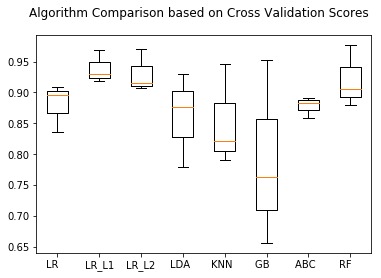

[[array([0.89587242, 0.83562368, 0.90875   ]),
  array([0.92917448, 0.96934461, 0.91875   ]),
  array([0.91510319, 0.96987315, 0.90625   ]),
  array([0.77908068, 0.87579281, 0.93      ]),
  array([0.82035647, 0.94635307, 0.790625  ]),
  array([0.65572233, 0.95190275, 0.7625    ]),
  array([0.88344278, 0.89112051, 0.85875   ]),
  array([0.87945591, 0.97621564, 0.905625  ])]]

In [18]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison based on Cross Validation Scores')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

results_compare.append(results)
results_compare


### LR_L1 looks like the best choice 

### Sometimes the results change: 

- one time LR_L1 looks good, this time RF looks good (high mean, modest sdev)
- perhaps Random forest chooses groupings differently each time its run
- GB, ABC, and RF models did best on second TimeSeriesSplit, but worse again on final(longest) timeseries, whereas LRL2 was pretty consistent at above 90% AUC for each run of kfold, that said, the confusion matrix was better for each of these than any of the LR models


## 4. Evaluate Performances of the Algorithms on Validation Dataset <a id="4"></a>

### Logistic Regression

Logistic regression is the most commonly used statistical model for binary classification. It uses the logit model of relating log-odds of the dependent variable linearly with the predictor (explanatory) variables to learn a form of the following logistic function that is used to separate instances of the two different classes. 

\begin{align*}
Pr(y=1|x) = h_\beta(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  x)}} \text{ where $\beta_0$ is the intercept and $\beta$ is the vector of trained weights}
\end{align*}

The function returns a probability measure of which class a new instance is given its features, this measure is then used to make the final classification with some probability threshold, traditionally being 0.5.

The specific logistic function is learned through gradient descent which focuses on minimizing error calculated through some cost function. A typical approach is to use the following maximum-likelihood estimator to minimize error in predicted probabilities.

\begin{align*}
& J(\beta) = -\frac{1}{N}\sum_{i=1}^Ny_ilog(h_\beta(x_i)) + (1 - y_i)log(1 - h_\beta(x_i)) \\
& \text{ where $N$ is the number of observations, $h_\beta(x)$ is as defined above, and $y_i$ is the predicted class}
\end{align*}

A regularization term 

\begin{align*}
\lambda\sum_{i=1}^N|\beta_i| \text{ where $\lambda$ is a regularization parameter, }
\end{align*}

is often added to the cost function to prevent overfitting by penalizing large coefficients. This regularization can be L1 or L2 penalty depending on the problem at hand.

In [19]:
model = LogisticRegression(C=1e09) # high penalty 
LR = model.fit(df_training_features, df_training_targets)
training_predictions = LR.predict(df_training_features)
validation_predictions = LR.predict(df_validation_features)

prob_predictions = LR.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR.predict_proba(df_validation_features), axis=0)
all_predictions = np.append(training_predictions, validation_predictions, axis=0)

# number of predicted recession months in training
#print(len(training_predictions)-sum(training_predictions)) 

# number of predicted recession months in validation
#print(len(validation_predictions)-sum(validation_predictions))

# total number of predicted recession months
#print(len(all_predictions)-sum(all_predictions))
#plt.plot(validation_predictions)


In [20]:
# very messy; lots of false negatives; 
confusion_matrix(df_validation_targets,validation_predictions)

array([[  5,  21],
       [ 25, 222]], dtype=int64)

In [21]:
import datetime
# define periods of recession
rec_spans = []
#rec_spans.append([datetime.datetime(1957,8,1), datetime.datetime(1958,4,1)])   # # months   #cum
rec_spans.append([datetime.datetime(1960,4,1), datetime.datetime(1961,2,1)])    # 11 months
rec_spans.append([datetime.datetime(1969,12,1), datetime.datetime(1970,11,1)])  # 12 months 23
rec_spans.append([datetime.datetime(1973,11,1), datetime.datetime(1975,3,1)])   # 17 months 40  
rec_spans.append([datetime.datetime(1980,1,1), datetime.datetime(1980,6,1)])    # 6 months  46
rec_spans.append([datetime.datetime(1981,7,1), datetime.datetime(1982,10,1)])   # 16 months 62
rec_spans.append([datetime.datetime(1990,7,1), datetime.datetime(1991,2,1)])    # 8 months  70
#                                                                               70 actual months of recession in training
#12/1/1996 is cutoff between training and validation

# these dates do not coincide exactly with the Label's in the dataset; 
# e.g., 2001 recession started 12/2000 ending 7/2001 in the dataset above
# e.g., 2007 recession start date is 9/1/07 and ends 2/1/09
# we did shift Label by one month back so that we could predict recession with lag, but not 3 months
rec_spans.append([datetime.datetime(2001,3,1), datetime.datetime(2001,10,1)])   # 8 months  78
rec_spans.append([datetime.datetime(2007,12,1), datetime.datetime(2009,5,1)])   # 18 months 96 cum months
#                                                                               26 actual months of recession in validation

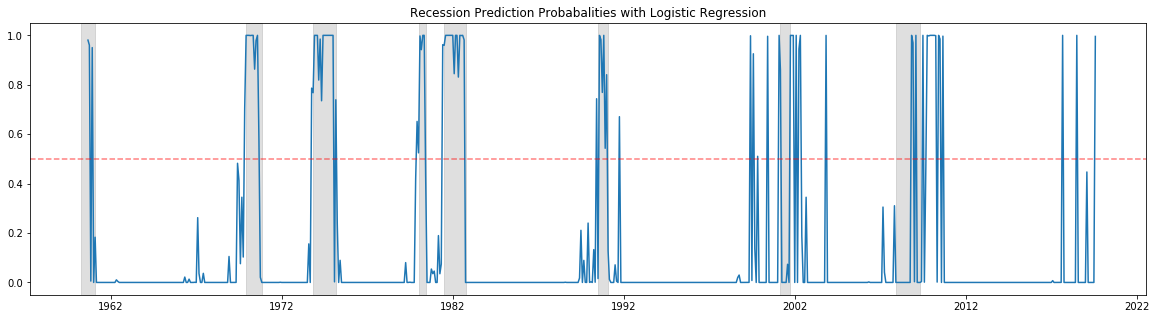

Total # of Official recessions:  8


In [22]:
sample_range = pd.date_range(start='9/1/1960', end='8/1/2019', freq='MS') #freq='MS' means 'month start' 

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0]) # prob_predictions has two columns; 
                                                                 # Prob(recession, i.e., Label=0), 
                                                                 # Prob(not recession, Label=Normal)
                                                                 # Can see that during validation period 12/1/96 - the 
                                                                 # lR model is very noisy
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5) # alpha is transparency: 1 opaque,0 invisible
plt.title('Recession Prediction Probabalities with Logistic Regression')
mp.savefig('plot1.png',  bbox_inches='tight')
plt.show()

# AMAZING how last 20 years, the Log Regression predicts a recession continuously - so much for 'economic recovery'
print('Total # of Official recessions: ',len(rec_spans))

### Conclusion: LR with no regularization is quite noisy for last two recessions, and is calling for recession with most recent data

# Logistic Regression with Regularization

In [23]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

model=LogisticRegression(max_iter=10000)
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(df_training_features,
                                                                       df_training_targets).best_estimator_
training_predictions=LR_penalty.predict(df_training_features)

In [24]:
# note that the best C = 0.2 vs. 0.1 before choosing subset of features
# Also note that GridSearch chose l1 penalty over L2 penalty
LR_penalty  

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
# NOTE that these are probabilities, not the actual predictions
prob_predictions = LR_penalty.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR_penalty.predict_proba(df_validation_features), axis=0) 

# NOTE that these are probabilities, not the actual predictions
y_predictions = LR_penalty.predict(df_training_features)
y_predictions = np.append(y_predictions , LR_penalty.predict(df_validation_features), axis=0) 


# we can see in chart below that the probabilities only barely reach to 50% for the last 3 recessions in early 1990s, 2000, 
# and 2007/8; we also see the noise during the validation period but the regularization worked well at attenuating that noise

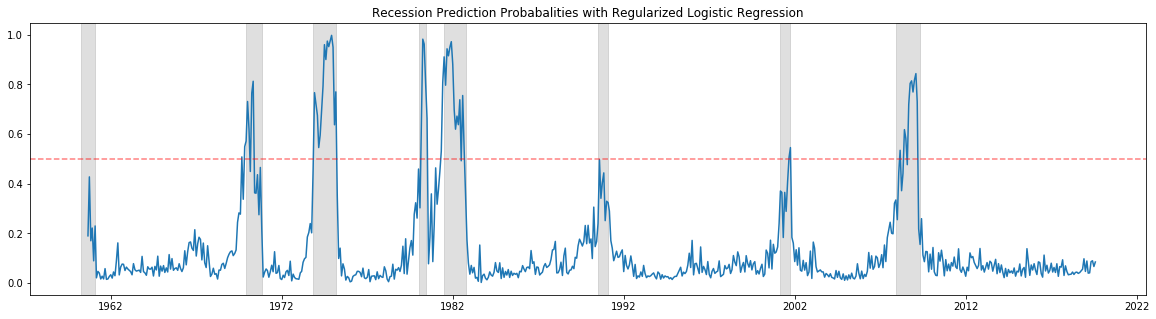

In [26]:
sample_range = pd.date_range(start='9/1/1960', end='8/1/2019', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values[:,], prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Regularized Logistic Regression')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()


In [27]:
confusion_matrix(df_validation_targets, LR_penalty.predict(df_validation_features))
# here we have very low false negative; some false positive

array([[ 11,  15],
       [  1, 246]], dtype=int64)

In [28]:
confusion_matrix(df_targets, LR_penalty.predict(df_features))

array([[ 49,  38],
       [  7, 614]], dtype=int64)

### Conclusion: LR with L1 regularization is quite good as a predictor with updated data, no recession in sight according as of 8/1/2019


In [48]:
# most important settings for Random Forest are 
# - the number of trees in the forest (n_estimators), and  
# - the number of features considered for splitting at each leaf node (max_features). 
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

gb = GradientBoostingClassifier()
ab = AdaBoostClassifier()
rf = RandomForestClassifier()

gb_model = gb.fit(df_training_features, df_training_targets)
# results to plot on timeseries plot
gb_prob_predictions = gb_model.predict_proba(df_training_features)
gb_prob_predictions = np.append(gb_prob_predictions, gb_model.predict_proba(df_validation_features), axis=0) 

ab_model = ab.fit(df_training_features, df_training_targets)
# results to plot on timeseries plot
ab_prob_predictions = ab_model.predict_proba(df_training_features)
ab_prob_predictions = np.append(ab_prob_predictions, ab_model.predict_proba(df_validation_features), axis=0) 

rf_model = rf.fit(df_training_features, df_training_targets)
# results to plot on timeseries plot
rf_prob_predictions = rf_model.predict_proba(df_training_features)
rf_prob_predictions = np.append(rf_prob_predictions, rf_model.predict_proba(df_validation_features), axis=0) 

rf_tuned_prob_predictions = rf_random.predict_proba(df_training_features)
rf_tuned_prob_predictions = np.append(rf_tuned_prob_predictions, rf_random.predict_proba(df_validation_features), axis=0) 


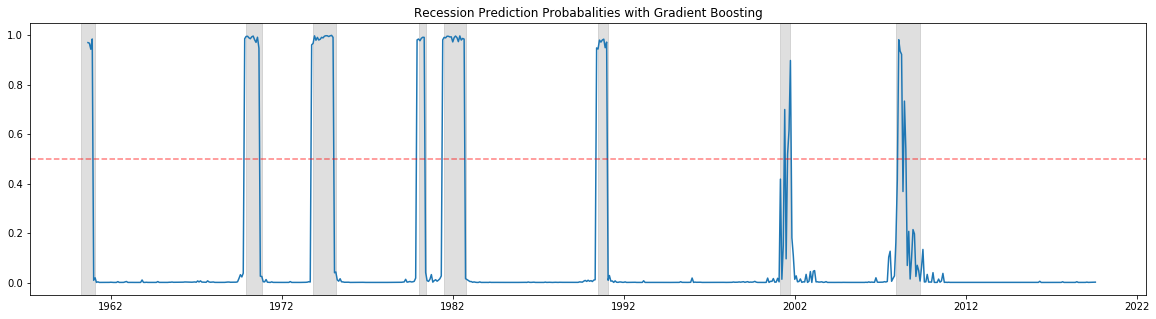

In [32]:
# for GB model
plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values[:,], gb_prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Gradient Boosting')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()


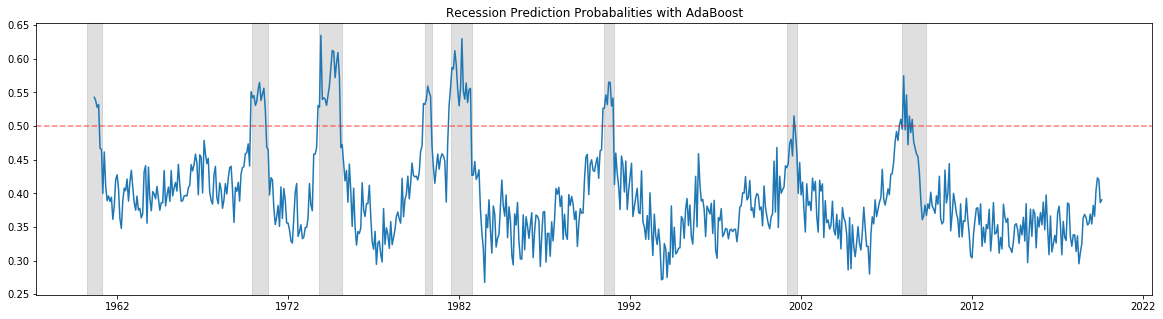

In [33]:
# for AB model
plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values[:,], ab_prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with AdaBoost')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()


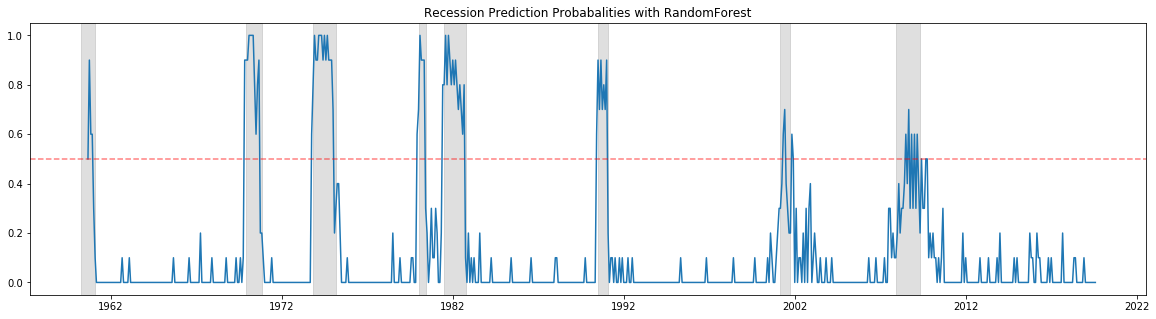

In [50]:
# for RF model
plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values[:,], rf_prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with RandomForest')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()


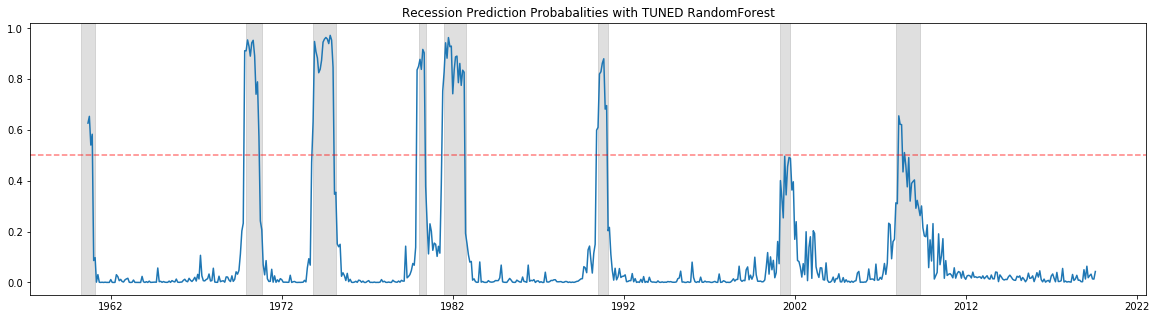

In [51]:
# for RF model
plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values[:,], rf_tuned_prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with TUNED RandomForest')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()

# Less noisy in more recent time periods

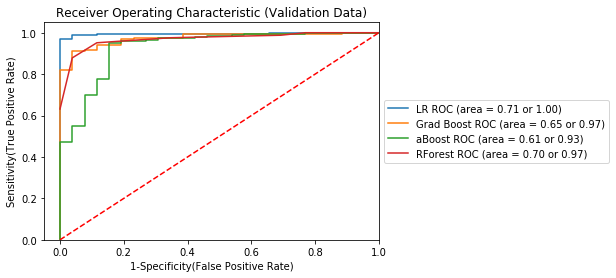

Last run on 2020-02-06 11:41:20 US/Eastern
Features included = 35
Model        Accuracy    F1 score
----------   --------    --------
LR penalty    0.941        0.969
Grad boost    0.930        0.963
A boost       0.923        0.959
RForest       0.930        0.962


In [35]:
fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR_penalty.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, LR_penalty.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('LR penalty', auc,auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, gb_model.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, gb_model.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('Grad Boost', auc,auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, ab_model.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, ab_model.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('aBoost', auc,auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, rf_model.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, rf_model.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('RForest', auc,auc2))

#fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, xgboost.predict_proba(df_validation_features)[:,1])
#auc = metrics.roc_auc_score(df_validation_targets,xgboost.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
#plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc,auc2))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validation Data)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC1.png',  bbox_inches='tight')
plt.show() 

#acc_LR = accuracy_score(df_validation_targets, LR.predict(df_validation_features))
acc_LR_penalty = accuracy_score(df_validation_targets, LR_penalty.predict(df_validation_features))
acc_gb = accuracy_score(df_validation_targets, gb_model.predict(df_validation_features))
acc_ab = accuracy_score(df_validation_targets, ab_model.predict(df_validation_features))
acc_rf = accuracy_score(df_validation_targets, rf_model.predict(df_validation_features))
#f1_LR  = f1_score(df_validation_targets, LR.predict(df_validation_features))
f1_LRp = f1_score(df_validation_targets, LR_penalty.predict(df_validation_features))
f1_gb = f1_score(df_validation_targets, gb_model.predict(df_validation_features))
f1_ab = f1_score(df_validation_targets, ab_model.predict(df_validation_features))
f1_rf = f1_score(df_validation_targets, rf_model.predict(df_validation_features))

ts=time.localtime()
print("Last run on", time.strftime('%Y-%m-%d %H:%M:%S', ts),'US/Eastern')
print("Features included =", len(df_features.columns)) 
print('Model        Accuracy    F1 score')
print('----------   --------    --------')
#print('LR           %0.3f        %0.3f' % (acc_LR, f1_LR))
print('LR penalty    %0.3f        %0.3f' % (acc_LR_penalty,f1_LRp))
print('Grad boost    %0.3f        %0.3f' % (acc_gb, f1_gb))
print('A boost       %0.3f        %0.3f' % (acc_ab, f1_ab))
print('RForest       %0.3f        %0.3f' % (acc_rf, f1_rf))



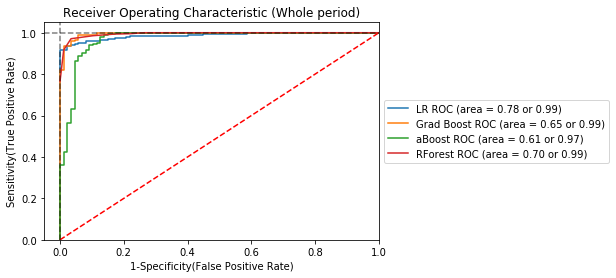

Last run on 2020-02-06 11:41:32 US/Eastern
Features included = 35
Model        Accuracy    F1 score
----------   --------    --------
LR penalty    0.936        0.965
Grad boost    0.973        0.985
A boost       0.970        0.983
RForest       0.973        0.985


In [36]:
fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR_penalty.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets, LR_penalty.predict(df_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('LR penalty', auc,auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, gb_model.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, gb_model.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('Grad Boost', auc,auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, ab_model.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, ab_model.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('aBoost', auc,auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, rf_model.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, rf_model.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('RForest', auc,auc2))

#fpr, tpr, thresholds = metrics.roc_curve(df_targets, xgboost.predict_proba(df_features)[:,1])
#auc = metrics.roc_auc_score(df_targets,xgboost.predict(df_features))
#plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Whole period)')
plt.axhline(y=1, color='k', ls='dashed', alpha = 0.5)
plt.axvline(x=0, color='k', ls='dashed', alpha = 0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC2.png',  bbox_inches='tight')
plt.show() 


#acc_LR = accuracy_score(df_targets, LR.predict(df_features))
acc_LR_penalty = accuracy_score(df_targets, LR_penalty.predict(df_features))
acc_gb = accuracy_score(df_targets, gb_model.predict(df_features))
acc_ab = accuracy_score(df_targets, ab_model.predict(df_features))
acc_rf = accuracy_score(df_targets, rf_model.predict(df_features))

#f1_LR = f1_score(df_targets, LR.predict(df_features))
f1_LRp = f1_score(df_targets, LR_penalty.predict(df_features))
f1_gb = f1_score(df_targets, gb_model.predict(df_features))
f1_ab = f1_score(df_targets, ab_model.predict(df_features))
f1_rf = f1_score(df_targets, rf_model.predict(df_features))

ts=time.localtime()
print("Last run on", time.strftime('%Y-%m-%d %H:%M:%S', ts),'US/Eastern')
print("Features included =", len(df_features.columns)) 
print('Model        Accuracy    F1 score')
print('----------   --------    --------')
#print('LR           %0.3f        %0.3f' % (acc_LR, f1_LR))
print('LR penalty    %0.3f        %0.3f' % (acc_LR_penalty,f1_LRp))
print('Grad boost    %0.3f        %0.3f' % (acc_gb, f1_gb))
print('A boost       %0.3f        %0.3f' % (acc_ab, f1_ab))
print('RForest       %0.3f        %0.3f' % (acc_rf, f1_rf))


# area given by metrics.roc_auc_score() DOES NOT look right, LR Penalty obviously has more area underneath 
# I think metrics.auc() function is more correct 

### Conclusion: Gradient boosting, Adaptive Boosting, and Random Forest models are also quite accurate during validation period, although slightly less than the Linear regressor with L1 regularization.  

- Still no recession in sight with any of these models on the updated data - 8/1/2019

### Next Steps
- try tuning GB and AB and RF hyperparameters, as perhaps this would yield different results from better versions of these models 
- starting point: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- use 36 features provided in updated dataset and attempt to do projections / scenarios to see how a recession could occur (NOTE this is probably beyond my expertise and/or would be too time consuming, but it would be an interesting exercise and is clearly in the realm of what other investment professionals are doing)

## RF tuning

In [41]:
from pprint import pprint

pprint(rf_model.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### We will try adjusting the following set of hyperparameters:
1. n_estimators = number of trees in the foreset
2. max_features = max number of features considered for splitting a node
3. max_depth = max number of levels in each decision tree
4. min_samples_split = min number of data points placed in a node before the node is split
5. min_samples_leaf = min number of data points allowed in a leaf node
6. bootstrap = method for sampling data points (with or without replacement)



In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [43]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(df_training_features, df_training_targets)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [44]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid2 = {
    'bootstrap': [False],
    'max_depth': [15, 25, 30],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1100, 1300, 1400]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid2, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(df_training_features, df_training_targets)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.8min finished


In [65]:
grid_search.best_params_


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1300}

In [67]:
rf_grid = grid_search.best_estimator_
rf_grid

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=1300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

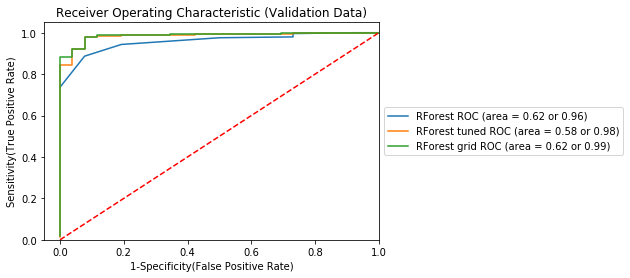

Last run on 2020-02-06 14:12:34 US/Eastern
Features included = 35
Model        Accuracy    F1 score
----------   --------    --------
RForest        0.912        0.953
RForest tuned  0.919        0.957
RForest grid   0.927        0.961


In [68]:
# compare on Validation data

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, rf_model.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, rf_model.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('RForest', auc,auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, rf_random.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, rf_random.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('RForest tuned', auc, auc2))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, rf_grid.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets, rf_grid.predict(df_validation_features))
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f or %0.2f)' % ('RForest grid', auc, auc2))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validation Data)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC1.png',  bbox_inches='tight')
plt.show() 

acc_rf =       accuracy_score(df_validation_targets, rf_model.predict(df_validation_features))
acc_rf_tuned = accuracy_score(df_validation_targets, rf_random.predict(df_validation_features))
acc_rf_grid  = accuracy_score(df_validation_targets, rf_grid.predict(df_validation_features))

f1_rf       = f1_score(df_validation_targets, rf_model.predict(df_validation_features))
f1_rf_tuned = f1_score(df_validation_targets, rf_random.predict(df_validation_features))
f1_rf_grid  = f1_score(df_validation_targets, rf_grid.predict(df_validation_features))

ts=time.localtime()
print("Last run on", time.strftime('%Y-%m-%d %H:%M:%S', ts),'US/Eastern')
print("Features included =", len(df_features.columns)) 
print('Model        Accuracy    F1 score')
print('----------   --------    --------')
print('RForest        %0.3f        %0.3f' % (acc_rf, f1_rf))
print('RForest tuned  %0.3f        %0.3f' % (acc_rf_tuned, f1_rf_tuned))
print('RForest grid   %0.3f        %0.3f' % (acc_rf_grid, f1_rf_grid))


## Conclusion: There is only a slight improvement in tuning the RF classifier with RandomizedSearchCV and slightly more benefit with GridSearchCV

- we'll skip optimizing Adaptive Boosting and Gradient boost, since AUC is above 95% for these already

## Potential Next steps:

- **high priority** - focus on other parts of modeling of market returns (ex: Scenario_Simulations_and_MultiPeriod_Optimization.ipynb and FactorModel.ipynb)
- **low priority** - work on projections of 35 features for making recession predictions using these models (this is probably more time consuming th
